## Estimate crop area based on crop mask

**Author**: Hannah Kerner (hkerner@umd.edu)

**Description**: This notebook contains:
1. Code for computing the confusion matrix between the labeled reference sample and the crop mask
2. Calculations for the crop and noncrop area and accuracy estimates based on [Olofsson et al., 2014](https://www.sciencedirect.com/science/article/abs/pii/S0034425714000704)

To be added in the future:
- Code for thresholding the crop mask to a binary mask of 0 (noncrop) or 1 (crop)
- Code for clipping the rectangular crop mask to the bounds of a regional shapefile
- Code for creating a random stratified sample from the crop mask for labeling in CEO
- A separate notebook for estimating area from a change map (based on crop masks from 2 years)
- Code for sub-regional estimates (subsetting the reference sample according to admin2 bounds, e.g.), probably as a separate notebook

In [67]:
# Import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## 1. Load the crop mask

In [13]:
mask_path = '/Users/hkerner/data/china/binary_masks/Liaoning_2017_epsg32651.tif'

In [14]:
with rio.open(mask_path) as src:
    if src.meta['crs'] == 'epsg:4326':
        print('''WARNING: The map CRS is EPSG:4326. This means the map unit is degrees 
              and the pixel-wise areas will not be in meters. You need to reproject the map
              to the projection defined for the map's primary UTM zone (e.g., EPSG:32652).''')
    if src.meta['dtype'] != 'uint8':
        print('''WARNING: The map data type is %s but should be uint8. Make sure the map has
              been thresholded to convert to a binary mask of 0 (noncrop) or 1 (crop).''')
    else:
        print('Map CRS is %s. Loading map into memory.' % src.crs)
        crop_map = src.read(1).astype(np.uint8)

Map CRS is EPSG:32651. Loading map into memory.


In [15]:
# Plot the map to make sure it looks as expected
# This may take a while depending on the size of the map,
# so you may choose not to run this every time.
# plt.imshow(crop_map, cmap='YlGn');
# plt.axis('off');

## 2. Calculate the mapped area for each class

In [16]:
pixel_size = src.transform[0]
print('The pixel size is %f meters.' % pixel_size)

The pixel size is 10.000000 meters.


In [17]:
# Function to calculate mapped area in pixels or ha
def mapped_area(pred_map, unit='pixels', px_size=10):
    crop_px = np.where(pred_map.flatten() == 1)
    noncrop_px = np.where(pred_map.flatten() == 0)
    if unit == 'ha':
        # Multiply pixels by area per pixel and convert m to hectares
        crop_area = crop_px[0].shape[0] * (px_size*px_size) / 100000
        noncrop_area = noncrop_px[0].shape[0] * (px_size*px_size) / 100000
    elif unit == 'pixels':
        crop_area = int(crop_px[0].shape[0])
        noncrop_area = int(noncrop_px[0].shape[0])
    return crop_area, noncrop_area

In [18]:
crop_area_px, noncrop_area_px = mapped_area(crop_map)

print('Crop area [pixels] = %d' % crop_area_px)
print('Non-crop area [pixels] = %d' % noncrop_area_px)

Crop area [pixels] = 556725045
Non-crop area [pixels] = 909501053


In [97]:
tot_area_px = crop_area_px + noncrop_area_px
print('Total area [pixels] = %d' % tot_area_px)

Total area [pixels] = 1466226098


In [19]:
crop_area_ha, noncrop_area_ha = mapped_area(crop_map, unit='ha', px_size=pixel_size)

print('Crop area [ha] = %d' % crop_area_ha)
print('Non-crop area [ha] = %d' % noncrop_area_ha)

Crop area [ha] = 556725
Non-crop area [ha] = 909501


## 3. Load the labeled reference samples

There should be two sets of labels for the reference sample. We compare the labels from each set to filter out labels for which the labelers did not agree and thus we can't be confident about the true label.

In [24]:
ceo_set1 = pd.read_csv('/Users/hkerner/src/china-crop-mask/area_estimation/reference_samples/labeled_ceo/ceo-Liaoning-2017-(Set-1)-sample-data-2021-04-09.csv')
ceo_set1.head()

,plot_id,sample_id,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_plotid,Does this point fall within active cropland?
0,139406454,543184480,121.672992,39.506624,NaN,NaN,NaN,NaN,NaN,NaN,POINT(121.672992236843 39.5066237413178),0,NaN
1,139406455,543184481,122.626644,42.312242,hkerner@umd.edu,False,2021-03-28 23:40,184.6 secs,Sentinel-2,NaN,POINT(122.626643742464 42.3122420366798),1,Crop
2,139406456,543184482,120.931343,42.112457,bev@jjjbsa.com,False,2021-03-28 23:42,111.8 secs,Sentinel-2,NaN,POINT(120.931343138274 42.1124567174916),2,Crop
3,139406457,543184483,119.447686,41.042653,hkerner@umd.edu,False,2021-03-30 00:07,56.2 secs,Planet Monthly Mosaics,NaN,POINT(119.447685615022 41.0426530456337),3,Non-crop
4,139406458,543184484,123.682973,43.058922,bev@jjjbsa.com,False,2021-03-28 23:43,46.4 secs,Sentinel-2,NaN,POINT(123.68297268506 43.0589217008399),4,Crop


In [25]:
ceo_set2 = pd.read_csv('/Users/hkerner/src/china-crop-mask/area_estimation/reference_samples/labeled_ceo/ceo-Liaoning-2017-(Set-2)-sample-data-2021-04-09.csv')
ceo_set2.head()

,plot_id,sample_id,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_plotid,Does this point fall within active cropland?
0,139417122,543272740,121.672992,39.506624,NaN,NaN,NaN,NaN,NaN,NaN,POINT(121.672992236843 39.5066237413178),0,NaN
1,139417123,543272741,122.626644,42.312242,bbarker1@umd.edu,False,2021-03-29 17:39,13.6 secs,Planet Monthly Mosaics,NaN,POINT(122.626643742464 42.3122420366798),1,Crop
2,139417124,543272742,120.931343,42.112457,bbarker1@umd.edu,False,2021-03-29 17:39,12.4 secs,Planet Monthly Mosaics,NaN,POINT(120.931343138274 42.1124567174916),2,Crop
3,139417125,543272743,119.447686,41.042653,bbarker1@umd.edu,False,2021-03-29 17:39,10.3 secs,Planet Monthly Mosaics,NaN,POINT(119.447685615022 41.0426530456337),3,Non-crop
4,139417126,543272744,123.682973,43.058922,bbarker1@umd.edu,False,2021-03-29 17:39,11.4 secs,Planet Monthly Mosaics,NaN,POINT(123.68297268506 43.0589217008399),4,Crop


In [29]:
# Make sure the question and thus column name is correct for the project you are working on
ceo_agree = ceo_set1[ceo_set1['Does this point fall within active cropland?'] == 
                         ceo_set2['Does this point fall within active cropland?']]

print('Number of samples that are in agreement: %d out of %d (%.2f%%)' % 
          (ceo_agree.shape[0], ceo_set1.shape[0], ceo_agree.shape[0]/ceo_set1.shape[0]*100))

Number of samples that are in agreement: 468 out of 525 (89.14%)


In [46]:
# Convert the pandas dataframe to a geodataframe
ceo_agree_geom = gpd.GeoDataFrame(ceo_agree, geometry=gpd.points_from_xy(ceo_agree.lon, ceo_agree.lat, crs='EPSG:4326'))

In [47]:
# The labeling platform CEO requires points to be in EPSG:4326. 
# Reproject to the same crs as the map.
ceo_agree_geom = ceo_agree_geom.to_crs(src.crs)

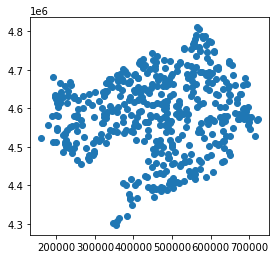

In [55]:
# Plot them to make sure they look as expected
ceo_agree_geom.plot();

## 4. Get the mapped class for each of the reference samples

In [62]:
for r, row in ceo_agree_geom.iterrows():
    # transform lon, lat to pixel coordinates
    lon, lat = row['geometry'].y, row['geometry'].x
    px, py = src.index(lat, lon)
    ceo_agree_geom.loc[r,'Mapped class'] = crop_map[px, py]

In [63]:
ceo_agree_geom.head()

,plot_id,sample_id,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_plotid,Does this point fall within active cropland?,Mapped class,geometry
1,139406455,543184481,122.626644,42.312242,hkerner@umd.edu,False,2021-03-28 23:40,184.6 secs,Sentinel-2,NaN,POINT(122.626643742464 42.3122420366798),1,Crop,1,POINT (469231.124 4684512.533)
2,139406456,543184482,120.931343,42.112457,bev@jjjbsa.com,False,2021-03-28 23:42,111.8 secs,Sentinel-2,NaN,POINT(120.931343138274 42.1124567174916),2,Crop,1,POINT (328976.929 4664333.126)
3,139406457,543184483,119.447686,41.042653,hkerner@umd.edu,False,2021-03-30 00:07,56.2 secs,Planet Monthly Mosaics,NaN,POINT(119.447685615022 41.0426530456337),3,Non-crop,0,POINT (201410.940 4549573.978)
4,139406458,543184484,123.682973,43.058922,bev@jjjbsa.com,False,2021-03-28 23:43,46.4 secs,Sentinel-2,NaN,POINT(123.68297268506 43.0589217008399),4,Crop,1,POINT (555614.847 4767584.300)
5,139406459,543184485,124.889949,42.546074,bev@jjjbsa.com,False,2021-03-28 23:45,99.6 secs,Mapbox Satellite,NaN,POINT(124.889949100803 42.5460735051361),5,Non-crop,0,POINT (655178.208 4712139.949)


In [65]:
# Make sure none of them are nodata
ceo_agree[ceo_agree_geom['Mapped class'] == 3]

,plot_id,sample_id,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_plotid,Does this point fall within active cropland?,Mapped class,geometry


## 5. Compute the confusion matrix between the mapped classes and reference labels

In [66]:
# Convert the CEO string label to an integer label
ceo_agree_geom.loc[ceo_agree_geom['Does this point fall within active cropland?'] == 'Crop', 'Reference label'] = 1
ceo_agree_geom.loc[ceo_agree_geom['Does this point fall within active cropland?'] == 'Non-crop', 'Reference label'] = 0
ceo_agree_geom['Reference label'] = ceo_agree_geom['Reference label'].astype(np.uint8)
ceo_agree_geom.head()

,plot_id,sample_id,lon,lat,email,flagged,collection_time,analysis_duration,imagery_title,imagery_attributions,sample_geom,pl_plotid,Does this point fall within active cropland?,Mapped class,geometry,Reference label
1,139406455,543184481,122.626644,42.312242,hkerner@umd.edu,False,2021-03-28 23:40,184.6 secs,Sentinel-2,NaN,POINT(122.626643742464 42.3122420366798),1,Crop,1,POINT (469231.124 4684512.533),1
2,139406456,543184482,120.931343,42.112457,bev@jjjbsa.com,False,2021-03-28 23:42,111.8 secs,Sentinel-2,NaN,POINT(120.931343138274 42.1124567174916),2,Crop,1,POINT (328976.929 4664333.126),1
3,139406457,543184483,119.447686,41.042653,hkerner@umd.edu,False,2021-03-30 00:07,56.2 secs,Planet Monthly Mosaics,NaN,POINT(119.447685615022 41.0426530456337),3,Non-crop,0,POINT (201410.940 4549573.978),0
4,139406458,543184484,123.682973,43.058922,bev@jjjbsa.com,False,2021-03-28 23:43,46.4 secs,Sentinel-2,NaN,POINT(123.68297268506 43.0589217008399),4,Crop,1,POINT (555614.847 4767584.300),1
5,139406459,543184485,124.889949,42.546074,bev@jjjbsa.com,False,2021-03-28 23:45,99.6 secs,Mapbox Satellite,NaN,POINT(124.889949100803 42.5460735051361),5,Non-crop,0,POINT (655178.208 4712139.949),0


In [72]:
# Compute confusion matrix
y_true = np.array(ceo_agree_geom['Reference label']).astype(np.uint8)
y_pred = np.array(ceo_agree_geom['Mapped class']).astype(np.uint8)
confusion_matrix(y_true, y_pred)

array([[179,  26],
       [ 15, 248]])

In [69]:
# Extract and print confusion matrix values with element descriptions
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('True negatives: %d' % tn)
print('False positives: %d' % fp)
print('False negatives: %d' % fn)
print('True positives: %d' % tp)

True negatives: 179
False positives: 26
False negatives: 15
True positives: 248


## 6. Adjust mapped area using confusion matrix to compute area estimates

$W_h$ is the proportion of mapped area for each class 

In [98]:
wh_crop = crop_area_px / tot_area_px
print('Wh_crop = %f' % wh_crop)

wh_noncrop = noncrop_area_px / tot_area_px
print('Wh_noncrop = %f' % wh_noncrop)

Wh_crop = 0.379699
Wh_noncrop = 0.620301


Compute the fraction of the proportional area of each class that was mapped as each category in the confusion matrix

In [99]:
tp_area = tp / (tp + fp) * wh_crop
fp_area = fp / (tp + fp) * wh_crop
fn_area = fn / (fn + tn) * wh_noncrop
tn_area = tn / (fn + tn) * wh_noncrop

print('%f \t %f \n %f \t %f' % (tp_area, fp_area, fn_area, tn_area))

0.343669 	 0.036030 
 0.047961 	 0.572339


$U_i$ is the user's accuracy (i.e., precision) for each mapped class. We calculate it here in terms of proportion of area computed in the last cell.

In [100]:
u_crop = tp_area / (tp_area + fp_area)
print('U_crop = %f' % u_crop)

u_noncrop = tn_area / (tn_area + fn_area)
print('U_noncrop = %f' % u_noncrop)

U_crop = 0.905109
U_noncrop = 0.922680


$V(U_i)$ is the estimated variance of user accuracy for each mapped class.

In [127]:
v_u_crop = u_crop * (1-u_crop) / (tp + fp)
print('V(U)_crop = %f' % v_u_crop)

v_u_noncrop = u_noncrop * (1-u_noncrop) / (fn + tn)
print('V(U)_noncrop = %f' % v_u_noncrop)

V(U)_crop = 0.000313
V(U)_noncrop = 0.000368


$S(U_i)$ is the estimated standard error of user accuracy for each mapped class.

In [128]:
s_u_crop = np.sqrt(v_u_crop)
print('S(U)_crop = %f' % s_u_crop)

s_u_noncrop = np.sqrt(v_u_noncrop)
print('S(U)_noncrop = %f' % s_u_noncrop)

S(U)_crop = 0.017705
S(U)_noncrop = 0.019177


Get the 95% confidence interval for User's accuracy

In [130]:
u_crop_err = s_u_crop * 1.96
print('95%% CI of User accuracy for crop = %f' % u_crop_err)

u_noncrop_err = s_u_noncrop * 1.96
print('95%% CI of User accuracy for noncrop = %f' % u_noncrop_err)

95% CI of User accuracy for crop = 0.034701
95% CI of User accuracy for noncrop = 0.037586


$P$ is the producer's accuracy (i.e., recall). We calculate it here in terms of proportion of area.

In [101]:
p_crop = tp_area / (tp_area + fn_area)
print('P_crop = %f' % p_crop)

p_noncrop = tn_area / (tn_area + fp_area)
print('P_noncrop = %f' % p_noncrop)

P_crop = 0.877534
P_noncrop = 0.940776


$N_j$ is the estimated marginal total number of pixels of each reference class $j$

In [140]:
n_j_crop = (crop_area_px * tp) / (tp + fp) + (noncrop_area_px * fn) / (fn + tn)
print('N_j_crop = %f' % n_j_crop)

n_j_noncrop = (crop_area_px * fp) / (tp + fp) + (noncrop_area_px * tn) / (fn + tn)
print('N_j_crop = %f' % n_j_noncrop)

N_j_crop = 574219367.387877
N_j_crop = 892006730.612123


In [143]:
expr1_crop = crop_area_px**2 * (1-p_crop)**2 * u_crop * (1-u_crop) / (tp + fp - 1)
print('expr1 crop = %f' % expr1_crop)

expr1_noncrop = noncrop_area_px**2 * (1-p_noncrop)**2 * u_noncrop * (1-u_noncrop) / (fp + tn - 1)
print('expr1 noncrop = %f' % expr1_noncrop)

expr1 crop = 1462421529819.369141
expr1 noncrop = 1014630471333.606812


In [152]:
# Warning: depending on the size of your map, you may get an overflow warning here, e.g.
# RuntimeWarning: overflow encountered in long_scalars
# Need to figure out if we can correct this...
expr2_crop = p_crop**2 * (noncrop_area_px**2 * fn / (fn + tn) * (1 - fn / (fn + tn)) / (fn + tn - 1))
print('expr2 crop = %f' % expr2_crop)

expr2_noncrop = p_crop**2 * (crop_area_px**2 * fp / (fp + tp) * (1 - fp / (fp + tp)) / (fp + tp - 1))
print('expr2 noncrop = %f' % expr2_noncrop)

expr2 crop = -114597572828040.062500
expr2 noncrop = 75088055100658.218750


/Users/hkerner/anaconda3/envs/area_estimation/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in long_scalars
  after removing the cwd from sys.path.


$V(P_i)$ is the estimated variance of producer's accuracy for each mapped class.

In [153]:
v_p_crop = (1 / n_j_crop**2) * (expr1_crop + expr2_crop)
print('V(P) crop = %f' % v_p_crop)

v_p_noncrop = (1 / n_j_noncrop**2) * (expr1_noncrop + expr2_noncrop)
print('V(P) noncrop = %f' % v_p_noncrop)

V(P) crop = -0.000343
V(P) noncrop = 0.000096


$S(P_i)$ is the estimated standard error of producer accuracy for each mapped class.

In [154]:
# Warning: depending on the size of your map, you may get an overflow warning here, e.g.
# RuntimeWarning: overflow encountered in long_scalars
# Need to figure out if we can correct this...
s_p_crop = np.sqrt(v_p_crop)
print('S(P) crop = %f' % s_p_crop)

s_p_noncrop = np.sqrt(v_p_noncrop)
print('S(P) noncrop = %f' % s_p_noncrop)

S(P) crop = nan
S(P) noncrop = 0.009780


/Users/hkerner/anaconda3/envs/area_estimation/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Get the 95% confidence interval for Producer's accuracy

In [155]:
p_crop_err = s_p_crop * 1.96
print('95%% CI of Producer accuracy for crop = %f' % p_crop_err)

p_noncrop_err = s_p_noncrop * 1.96
print('95%% CI of Producer accuracy for noncrop = %f' % p_noncrop_err)

95% CI of Producer accuracy for crop = nan
95% CI of Producer accuracy for noncrop = 0.019168


$O$ is the overall accuracy. We calculate it here in terms of proportion of area.

In [102]:
acc = tp_area + tn_area
print('Overall accuracy = %f' % acc)

Overall accuracy = 0.916009


$V(O)$ is the estimated variance of the overall accuracy

In [157]:
v_acc = wh_crop**2 * u_crop * (1-u_crop) / (tp + fp - 1) + \
        wh_noncrop**2 * u_noncrop * (1-u_noncrop) / (fn + tn - 1)
print('V(O) = %f' % v_acc)

V(O) = 0.000188


$S(O)$ is the estimated standard error of the overall accuracy

In [158]:
s_acc = np.sqrt(v_acc)
print('S(O) = %f' % s_acc)

S(O) = 0.013696


Get the 95% confidence interval for overall accuracy

In [160]:
acc_err = s_acc * 1.96
print('95%% CI of overall accuracy = %f' % acc_err)

95% CI of overall accuracy = 0.026845


$A_{pixels}$ is the adjusted map area in units of pixels

In [103]:
a_pixels_crop = tot_area_px * (tp_area + fn_area)
print('A^[pixels] crop = %f' % a_pixels_crop)

a_pixels_noncrop = tot_area_px * (tn_area + fp_area)
print('A^[pixels] noncrop = %f' % a_pixels_noncrop)

A^[pixels] crop = 574219367.387877
A^[pixels] noncrop = 892006730.612123


$A_{ha}$ is the adjusted map area in units of hectares

In [91]:
a_ha_crop = a_pixels_crop * (pixel_size*pixel_size) / (100*100)
print('A^[ha] crop = %f' % a_ha_crop)

a_ha_noncrop = a_pixels_noncrop * (pixel_size*pixel_size) / (100*100)
print('A^[ha] noncrop = %f' % a_ha_noncrop)

A^[ha] crop = 5742193.673879
A^[ha] noncrop = 8920067.306121


The following equations are used to estimate the standard error for the area. They are based on the calculations in Olofsson et al., 2014.

In [107]:
S_pk_crop = np.sqrt((wh_crop * tp_area - tp_area**2) / (tp + fp - 1) + \
                     (wh_noncrop * fn_area - fn_area**2) / (fn + tn - 1)) * tot_area_px
print('S_pk_crop = %f' % S_pk_crop)

S_pk_noncrop = np.sqrt((wh_crop * fp_area - fp_area**2) / (tp + fp - 1) + \
                        (wh_noncrop * tn_area - tn_area**2) / (fn + tn - 1)) * tot_area_px
print('S_pk_noncrop = %f' % S_pk_noncrop)

S_pk_crop = 20081710.316704
S_pk_noncrop = 20081710.316704


Multiply $S(p_k)$ by 1.96 to get the margin of error for the 95% confidence interval

In [111]:
a_pixels_crop_err = S_pk_crop * 1.96
print('Crop area standard error 95%% confidence interval [pixels] = %f' % a_pixels_crop_err)

a_pixels_noncrop_err = S_pk_noncrop * 1.96
print('Non-crop area standard error 95%% confidence interval [pixels] = %f' % a_pixels_noncrop_err)

Crop area standard error 95% confidence interval [pixels] = 39360152.220740
Non-crop area standard error 95% confidence interval [pixels] = 39360152.220740


In [112]:
a_ha_crop_err = a_pixels_crop_err * (pixel_size**2) / (100**2)
print('Crop area standard error 95%% confidence interval [ha] = %f' % a_ha_crop_err)

a_ha_noncrop_err = a_pixels_noncrop_err * (pixel_size**2) / (100**2)
print('Non-crop area standard error 95%% confidence interval [ha] = %f' % a_ha_noncrop_err)

Crop area standard error 95% confidence interval [ha] = 393601.522207
Non-crop area standard error 95% confidence interval [ha] = 393601.522207


Summary of the final estimates of accuracy and area with standard error at 95% confidence intervals:

In [163]:
summary = pd.DataFrame([[a_ha_crop, a_ha_noncrop],
                        [a_ha_crop_err, a_ha_noncrop_err],
                        [u_crop, u_noncrop],
                        [u_crop_err, u_noncrop_err],
                        [p_crop, p_noncrop],
                        [p_crop_err, p_noncrop_err],
                        [acc, acc],
                        [acc_err, acc_err]
                       ],
                       index=pd.Index(['Estimated area [ha]', '95% CI of area [ha]', 'User accuracy',
                                       '95% CI of user acc', 'Producer accuracy', '95% CI of prod acc',
                                       'Overall accuracy', '95% CI of overall acc']),
                       columns=['Crop', 'Non-crop'])

summary.round(2)

,Crop,Non-crop
Estimated area [ha],5742193.67,8920067.31
95% CI of area [ha],393601.52,393601.52
User accuracy,0.91,0.92
95% CI of user acc,0.03,0.04
Producer accuracy,0.88,0.94
95% CI of prod acc,NaN,0.02
Overall accuracy,0.92,0.92
95% CI of overall acc,0.03,0.03
